In [1]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView, pbfs_search, BFSVisitor, Graph, min_spanning_tree
from networkx.drawing.nx_agraph import graphviz_layout

from cascade import gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.1

pos = graphviz_layout(gnx, root=0)

In [2]:
infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, model='si', return_tree=True)

In [62]:
from steiner_tree_mst import *
def build_closure(g, cand_source, terminals, infection_times, k=-1,
                  strictly_smaller=True,
                  debug=False,
                  verbose=False):
    """
    build a clojure graph in which cand_source + terminals are all connected to each other.
    the number of neighbors of each node is determined by k

    the larger the k, the denser the graph"""
    r2pred = {}
    edges = {}
    terminals = list(terminals)

    # from cand_source to terminals
    vis = init_visitor(g, cand_source)
    cpbfs_search(g, source=cand_source, visitor=vis, terminals=terminals,
                 forbidden_nodes=terminals,
                 count_threshold=k)
    r2pred[cand_source] = vis.pred
    for u, v, c in get_edges(vis.dist, cand_source, terminals):
        edges[(u, v)] = c
    if debug:
        print('cand_source: {}'.format(cand_source))
        print('#terminals: {}'.format(len(terminals)))
        print('edges from cand_source: {}'.format(edges))

    if verbose:
        terminals_iter = tqdm(terminals)
        print('building closure graph')
    else:
        terminals_iter = terminals

    # from terminal to other terminals
    for root in terminals_iter:
        vis = init_visitor(g, root)

        if strictly_smaller:
            late_terminals = [t for t in terminals
                              if infection_times[t] > infection_times[root]]
        else:
            # respect what the paper presents
            late_terminals = [t for t in terminals
                              if infection_times[t] >= infection_times[root]]

        late_terminals = set(late_terminals) - {cand_source}  # no one can connect to cand_source
        if debug:
            print('root: {}'.format(root))
            print('late_terminals: {}'.format(late_terminals))
        cpbfs_search(g, source=root, visitor=vis, terminals=list(late_terminals),
                     forbidden_nodes=list(set(terminals) - set(late_terminals)),
                     count_threshold=k)
        r2pred[root] = vis.pred
        for u, v, c in get_edges(vis.dist, root, late_terminals):
            if debug:
                print('edge ({}, {})'.format(u, v))
            edges[(u, v)] = c

    if verbose:
        print('returning closure graph')

    gc = Graph(directed=True)

    for _ in range(g.num_vertices()):
        gc.add_vertex()

    for (u, v) in edges:
        gc.add_edge(u, v)

    eweight = gc.new_edge_property('int')
    eweight.set_2d_array(np.array(list(edges.values())))
    # for e, c in edges.items():
    #     eweight[e] = c
    return gc, eweight, r2pred

def steiner_tree_mst(g, root, infection_times, source, terminals,
                     strictly_smaller=True,
                     return_closure=False,
                     k=-1,
                     debug=False,
                     verbose=True):
    gc, eweight, r2pred = build_closure(g, root, terminals,
                                        infection_times,
                                        strictly_smaller=strictly_smaller,
                                        k=k,
                                        debug=debug,
                                        verbose=verbose)

    # get the minimum spanning arborescence
    # graph_tool does not provide minimum_spanning_arborescence
    if verbose:
        print('getting mst')
    gx = gt2nx(gc, root, terminals, edge_attrs={'weight': eweight})
#     print('type', type(gx))
#     print('gx.edges()', gx.edges())
    try:
        nx_tree = nx.minimum_spanning_arborescence(gx, 'weight')
#         print('nx_tree.edges()', nx_tree.edges())
    except nx.exception.NetworkXException:
        if debug:
            print('fail to find mst')
        return None

    if verbose:
        print('returning tree')


    mst_tree = Graph(directed=True)
    for _ in range(g.num_vertices()):
        mst_tree.add_vertex()
    
    for u, v in nx_tree.edges():
        mst_tree.add_edge(u, v)

    if verbose:
        print('extract edges from original graph')

    # return None, gc, mst_tree

    # extract the edges from the original graph   
    
    # sort observations by time
    # and also topological order
    topological_index = {}
    for i, e in enumerate(bfs_iterator(mst_tree, source=root)):
        topological_index[int(e.target())] = i
    sorted_obs = sorted(
        set(terminals) - {root},
        key=lambda o: (infection_times[o], topological_index[o]))
        
    tree_nodes = {root}
    tree_edges = set()
    # print('root', root)
    for u in sorted_obs:
        # print(u)
        v, u = map(int, next(mst_tree.vertex(u).in_edges()))  # v is ancestor
        tree_nodes.add(v)
        
        late_nodes = [n for n in terminals if infection_times[n] > infection_times[u]]
        vis = init_visitor(g, u)
        # from child to any tree node, including v
        
        cpbfs_search(g, source=u, terminals=list(tree_nodes),
                     forbidden_nodes=late_nodes,
                     visitor=vis,
                     count_threshold=1)
        reachable_tree_nodes = set(np.nonzero(vis.dist > 0)[0]).intersection(tree_nodes)
        ancestor = min(reachable_tree_nodes, key=vis.dist.__getitem__)
        
        edges = extract_edges_from_pred(g, u, ancestor, vis.pred)
        edges = {(j, i) for i, j in edges}  # need to reverse it
        if debug:
            print('tree_nodes', tree_nodes)
            print('connecting {} to {}'.format(v, u))
            print('using ancestor {}'.format(ancestor))
            print('adding edges {}'.format(edges))
        tree_nodes |= {u for e in edges for u in e}

        tree_edges |= edges

    t = Graph(directed=True)
    for _ in range(g.num_vertices()):
        t.add_vertex()

    for u, v in tree_edges:
        t.add_edge(t.vertex(u), t.vertex(v))

    tree_nodes = {u for e in tree_edges for u in e}
    vfilt = t.new_vertex_property('bool')
    vfilt.a = False
    for v in tree_nodes:
        vfilt[t.vertex(v)] = True

    t.set_vertex_filter(vfilt)

    if return_closure:
        return t, gc, mst_tree
    else:
        return t

In [35]:
from graph_tool.search import bfs_search, bfs_iterator
bfs_search
list(mst_tree.edges())

[<Edge object with source '0' and target '41' at 0x7f4a91912030>,
 <Edge object with source '0' and target '12' at 0x7f4a91912b20>,
 <Edge object with source '12' and target '5' at 0x7f4a91912c70>]

In [63]:
from utils import earliest_obs_node
from tqdm import tqdm
from feasibility import is_order_respected, is_feasible
# from steiner_tree_region_mst import steiner_tree_region_mst

for i in tqdm(range(100)):
    infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, model='si', return_tree=True)
    root = earliest_obs_node(obs_nodes, infection_times)
    if True:
        tree, gc, mst_tree = steiner_tree_mst(
            g, root, infection_times, source, obs_nodes,
            strictly_smaller=False,
            debug=False,
            verbose=False,
            return_closure=True
        )
    else:
        tree, gc, mst_tree = steiner_tree_region_mst(
            g, root, infection_times, source, obs_nodes,
            debug=False,
            return_closure=True
        )
    assert is_order_respected(tree, root, obs_nodes, infection_times)
    assert is_feasible(tree, root, obs_nodes, infection_times)

100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


In [52]:
print(root)
print(list(mst_tree.edges()))
print(list(gc.edges()))
print(list(tree.edges()))
list(mst_tree.vertex(59).in_edges())

28
[<Edge object with source '28' and target '44' at 0x7f4a91912ab0>, <Edge object with source '28' and target '54' at 0x7f4a91912420>, <Edge object with source '54' and target '62' at 0x7f4a918e0880>]
[<Edge object with source '28' and target '62' at 0x7f4a91912ab0>, <Edge object with source '28' and target '44' at 0x7f4a91912420>, <Edge object with source '28' and target '54' at 0x7f4a918e0880>, <Edge object with source '44' and target '62' at 0x7f4a918e0810>, <Edge object with source '54' and target '44' at 0x7f4a918e08f0>, <Edge object with source '54' and target '62' at 0x7f4a918e0ea0>, <Edge object with source '62' and target '44' at 0x7f4a918e09d0>]
[<Edge object with source '28' and target '36' at 0x7f4a91912ab0>, <Edge object with source '36' and target '44' at 0x7f4a91912420>, <Edge object with source '44' and target '45' at 0x7f4a918e0880>, <Edge object with source '45' and target '46' at 0x7f4a918e0810>, <Edge object with source '46' and target '54' at 0x7f4a918e08f0>, <Edg

[]

<IPython.core.display.Javascript object>


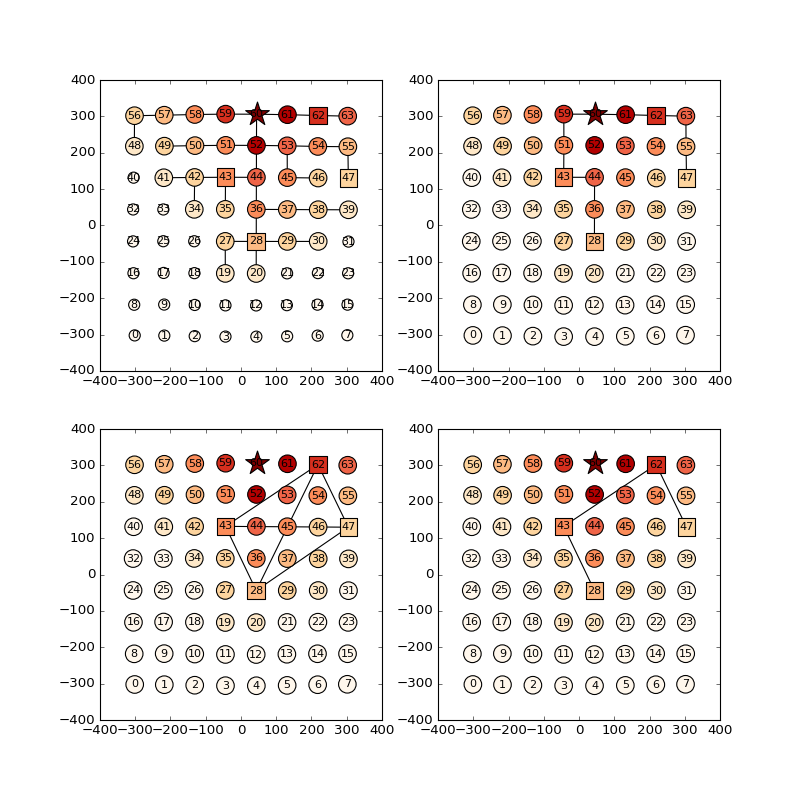

In [61]:
from plot_utils import plot_snapshot
from utils import extract_edges

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
             ax=ax[0, 1], arrows=True,
             edges=extract_edges(tree))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 0], arrows=True,
              edges=extract_edges(gc))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 1], arrows=True,
              edges=extract_edges(mst_tree))

In [7]:
list(mst_tree.edges())

[<Edge object with source '31' and target '14' at 0x7f4a59a3b880>,
 <Edge object with source '37' and target '58' at 0x7f4a59a3b500>,
 <Edge object with source '37' and target '31' at 0x7f4a59a3b420>]

In [8]:
original_tree, gc, mst_tree = steiner_tree_mst(g, source, 
                                               infection_times, source, 
                                               list(obs_nodes), return_closure=True, debug=True)

100%|██████████| 4/4 [00:00<00:00, 427.43it/s]

cand_source: 36
#terminals: 4
edges from cand_source: {(36, 37): 1.0, (36, 58): 5.0, (36, 31): 4.0, (36, 14): 5.0}
building closure graph
root: 58
late_terminals: set()
root: 14
late_terminals: set()
root: 37
late_terminals: {58, 14, 31}
edge (37, 58)
edge (37, 14)
edge (37, 31)
root: 31
late_terminals: set()
returning closure graph
getting mst
returning tree
extract edges from original graph
connecting 36 to 37
adding edges [(36, 37)]
connecting 36 to 58
adding edges [(59, 58), (60, 59), (52, 60), (44, 52), (36, 44)]
connecting 37 to 14
adding edges [(22, 14), (30, 22), (38, 30), (37, 38)]
connecting 37 to 31
adding edges [(39, 31), (47, 39), (46, 47), (45, 46), (37, 45)]


<IPython.core.display.Javascript object>


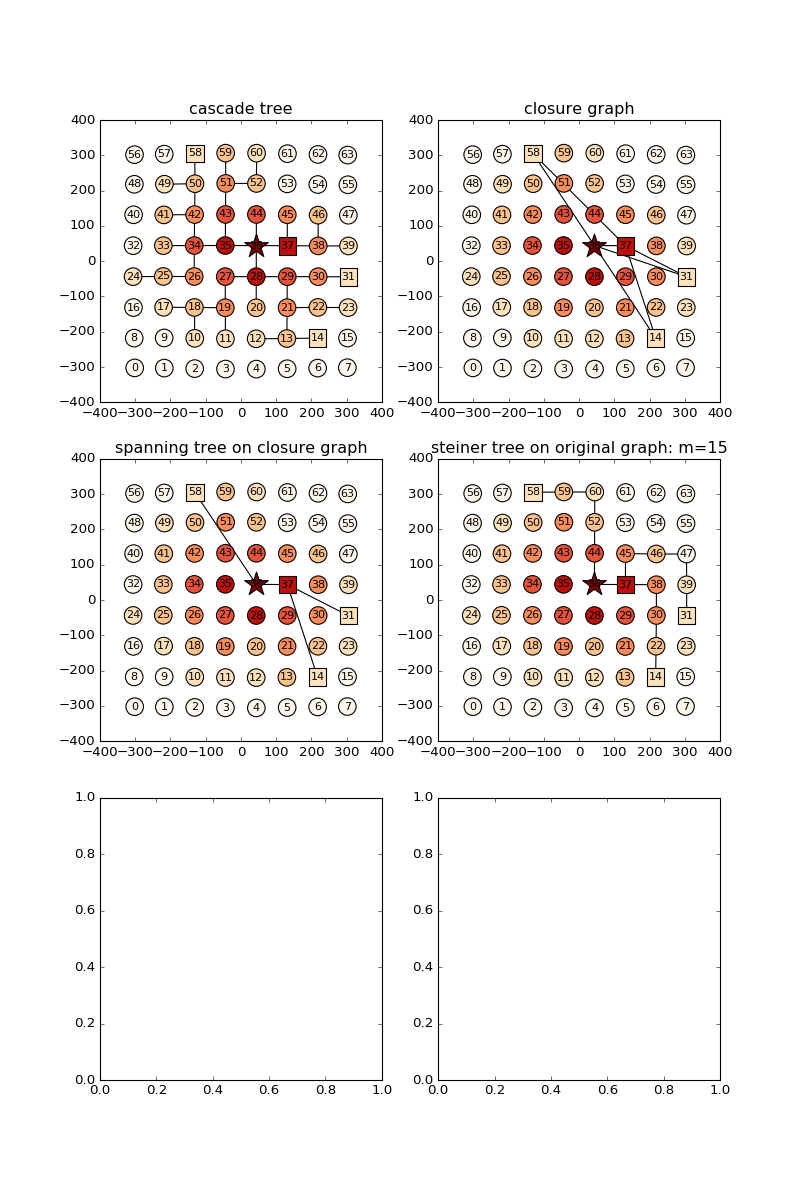

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
ax[0, 0].set_title('cascade tree')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              arrows=True,
              edges=extract_edges(gc))
ax[0, 1].set_title('closure graph')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 0],
              arrows=True,
              edges=extract_edges(mst_tree))
ax[1, 0].set_title('spanning tree on closure graph')
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 1],
              arrows=True,              
              edges=extract_edges(original_tree))
ax[1, 1].set_title('steiner tree on original graph: m={}'.format(original_tree.num_edges()))

In [10]:
%%timeit -r1 -n1
from steiner_tree_order import tree_sizes_by_roots
from utils import get_rank_index
sizes = tree_sizes_by_roots(g, obs_nodes, infection_times, source, method='mst')
get_rank_index(sizes, source)

100%|██████████| 4/4 [00:00<00:00, 2323.71it/s]


building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
retur

100%|██████████| 4/4 [00:00<00:00, 2373.01it/s]


extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original 

100%|██████████| 4/4 [00:00<00:00, 2343.84it/s]

extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original 


100%|██████████| 4/4 [00:00<00:00, 2333.09it/s]


extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original


100%|██████████| 4/4 [00:00<00:00, 2204.05it/s]


returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
building closure graph
returning closure graph
getting mst
returning tree
extract edges from original graph
1 loop, best of 1: 945 ms per loop
